# Time series clustering exercise

In [316]:
import os
import pandas as pd
import numpy as np
from zipfile import ZipFile
import geopandas as gpd
import urllib.request as urllib
from sklearn import preprocessing
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import silhouette_score
from matplotlib.colors import ListedColormap

# Data

Download the census bureau business data for all years 1993-2014. You can investigate using the API (I have not done it with the census bureau). I did is as you see below

The data is on the github repo. Each file is the economic census for 1 year. 
Download it programmatically and move it to PUIdata

 Download the NYC zipcodes shapefile. One of many ways in which you can get the zipcodes shapefile for NYC
 https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip


## You can use zipfile module in python to unzip the files
it should be installed in your system, but if it is not you can get the code with wget from here
https://github.com/python/cpython/blob/2.7/Lib/zipfile.py
remembering to use the raw link
(or you can use the usual shell commands)

In [4]:
#download shapefile, Move to PUIDATA, Read NYC zipcodes shapefile
NYC_zipcodes = gpd.GeoDataFrame.from_file(os.getenv('PUIDATA') + '/ZIP_CODE_040114.shp')
NYC_zipcodes.shape

(263, 13)

In [317]:
NYC_zipcodes.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [211]:
#get the zipcode from shapefile
zipcode = NYC_zipcodes[['ZIPCODE']]
zipcode.head()

,ZIPCODE
0,11436
1,11213
2,11212
3,11225
4,11218


In [6]:
def unzipfile(name):
    '''
    Unzip zip file by replace .zip to .txt
    '''
    zipfile = ZipFile(os.getenv('PUIDATA') + '/' + name)
    df = pd.read_csv(zipfile.open(name.replace('.zip', '.txt')))   
    return df

In [202]:
#the year that needs to unzip
year94_09 = ['9%s'%i for i in range(4,10)]
for i in range(10):
    year94_09.append('0%s'%i)

year10_14 = ['1%s'%i for i in range(5)]
year94_09, year10_14

(['94',
  '95',
  '96',
  '97',
  '98',
  '99',
  '00',
  '01',
  '02',
  '03',
  '04',
  '05',
  '06',
  '07',
  '08',
  '09'],
 ['10', '11', '12', '13', '14'])

In [212]:
#Unzip and merge year from 1994-2009
for i in year94_09:
    test = unzipfile('zbp%stotals.zip'%i)
    test1 = test[test.columns[[0,-1]]]
    zipcode['ZIPCODE'] = zipcode['ZIPCODE'].astype(int)
    test1[test1.columns[0]] = test1[test1.columns[0]].astype(int)
    zipcode = pd.merge(zipcode, test1, left_on = 'ZIPCODE', right_on = test1.columns[0])
    zipcode.drop(zipcode.columns[-2], axis=1, inplace=True)
    zipcode.rename(columns={zipcode.columns[-1]:i}, inplace=True)
zipcode.head()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ZIPCODE,94,95,96,97,98,99,00,01,02,03,04,05,06,07,08,09
0,11436,51,50,53,51,51,58,65,57,78,74,84,82,80,84,90,92
1,11213,406,420,433,456,476,473,477,493,546,569,570,556,565,556,592,621
2,11212,505,494,502,527,519,541,520,527,577,581,586,587,570,587,602,647
3,11225,381,387,388,410,416,409,417,422,479,488,492,491,499,514,520,543
4,11218,985,1015,1049,1075,1118,1149,1161,1180,1228,1247,1295,1332,1331,1377,1397,1457


In [213]:
#Continous unzip and merge year 2010-2014:
for i in year10_14:
    test = unzipfile('zbp%stotals.zip'%i)
    test1 = test[['zip','est']]
    zipcode['ZIPCODE'] = zipcode['ZIPCODE'].astype(int)
    test1['zip'] = test1['zip'].astype(int)
    zipcode = pd.merge(zipcode, test1, left_on = 'ZIPCODE', right_on = 'zip')
    zipcode.drop('zip', axis=1, inplace=True)
    zipcode.rename(columns={'est':i}, inplace=True)
zipcode.head()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ZIPCODE,94,95,96,97,98,99,00,01,02,...,05,06,07,08,09,10,11,12,13,14
0,11436,51,50,53,51,51,58,65,57,78,...,82,80,84,90,92,98,101,95,99,109
1,11213,406,420,433,456,476,473,477,493,546,...,556,565,556,592,621,675,674,726,755,772
2,11212,505,494,502,527,519,541,520,527,577,...,587,570,587,602,647,699,713,721,731,752
3,11225,381,387,388,410,416,409,417,422,479,...,491,499,514,520,543,580,597,623,673,696
4,11218,985,1015,1049,1075,1118,1149,1161,1180,1228,...,1332,1331,1377,1397,1457,1474,1523,1605,1687,1736


In [216]:
zipcode = zipcode.dropna()
zipcode.columns

Index(['ZIPCODE', '94', '95', '96', '97', '98', '99', '00', '01', '02', '03',
       '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14'],
      dtype='object')

In [217]:
zipcode.shape

(243, 22)

# Data cleaning

you may need to clean your data: for some NYC zip codes there may be no info
sanity check: you should have 20 (N_timestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)


IMPORTANT: read the instructions below on pre-processing. Afte rthat:

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



## TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means
    in **a few** clusters (as discussed there is no real good, sound way to 
    decide what a good number is here. try a few options, keeping in mind 
    a few is more than a couple, but i recommand you stay within the 
    single digit numbers)
    
    3. plot the cluster centers (if you used K means those are the means of 
    the clusters). you can plot for example the cluster centers overlayed on 
    each time series (using the alpha channel to control the opacity in the 
    plot may be helpful here).
    
    4. Use another clustering algorithm (of your choice)
    
    5. overlay your data on a NYC map: you can use shapefiles for the 
    zip codes and different colors for different clusters
    
    6. Compare the results of the 2 algorithms
    
    7. attempt an interpretation. this is dangerous ground: clustering is 
    an exploratory tool so you do not want to jump to conclusions because 
    you see some clusters! but seeing structure in your data can inform 
    your next moves as an investigator. 
    

Note on preprocessing: the preparation of these data should include the "standardization" of the time seris. 
*Always when you apply a moachine learning model you should standardize the data or whiten it.*
These operations may be complicated preprocessing operation, they can for example invoke PCA, and they are aimed at removing covariance in the feature space.

The simplest version of whitening *standardizes each feature*" from every column (feature) you subtract the mean and you divide it by the standard deviation.

But the time series preprocessing is different if you want to use each time stamp as feature: because you want to maintain the coherence of the data, i.e. you **do not want** to treat each feature as an independent feature! the pattenrs in the time series are what you are clustering on (time series goes up and down, creating a pattern) and those patterns would be lost by whitening.

*So when you cluster or otherwise use a time series in a model, using each timestamp as a feature, you want to standardize the observations, not the features.* 

**From each row of your table (observation, in this case each zipcode) subtract the mean and you divide the row by the standard deviation.**

In [9]:
import geopandas as gp
nyczipsshp = gp.read_file(os.getenv("PUIDATA") + "/ZIP_CODE_040114.shp")
#nyczipsshp.plot()
#nyczipsshp.drop_duplicates("ZIPCODE").plot()
#nyczipsshp
print("ZIPCODES:",
      len(np.unique(nyczipsshp.ZIPCODE)), "POLYGONS:",
      len(nyczipsshp.ZIPCODE),
      "the difference is due to island with same zip as parts of land,",
      "but disjoint shapes")
nyczips = nyczipsshp.ZIPCODE.values.astype(int)
print("number of NYC zip codes:", len(nyczips))

ZIPCODES: 248 POLYGONS: 263 the difference is due to island with same zip as parts of land, but disjoint shapes
number of NYC zip codes: 263


In [11]:
# 20 years of data and 263 zipcodes
cbs.shape

(263, 20)

In [13]:
#cleaning all missing values
cleancsb.shape

(260, 20)

In [ ]:
#then the standardization will look like:
vals = ((cleancsb.T - cleancsb.mean(1)) / cleancsb.std(1)).T


vals.mean(axis=1) should return 0 (or something very small) everywhere

vals.mean(axis=1).shape should be (260,)

vals.std(axis=1) should return 1 everywhere

vals.std(axis=1).shape

In [335]:
#original (243,22) Dataframe
clean = zipcode.copy()
clean.head()

,ZIPCODE,94,95,96,97,98,99,00,01,02,...,05,06,07,08,09,10,11,12,13,14
0,11436,51,50,53,51,51,58,65,57,78,...,82,80,84,90,92,98,101,95,99,109
1,11213,406,420,433,456,476,473,477,493,546,...,556,565,556,592,621,675,674,726,755,772
2,11212,505,494,502,527,519,541,520,527,577,...,587,570,587,602,647,699,713,721,731,752
3,11225,381,387,388,410,416,409,417,422,479,...,491,499,514,520,543,580,597,623,673,696
4,11218,985,1015,1049,1075,1118,1149,1161,1180,1228,...,1332,1331,1377,1397,1457,1474,1523,1605,1687,1736


In [433]:
#Seperate zipcode and time series (they have same index)
zipcode_label = clean[['ZIPCODE']]
time_series = clean.drop('ZIPCODE', axis=1)

In [434]:
time_series.head()

,94,95,96,97,98,99,00,01,02,03,...,05,06,07,08,09,10,11,12,13,14
0,51,50,53,51,51,58,65,57,78,74,...,82,80,84,90,92,98,101,95,99,109
1,406,420,433,456,476,473,477,493,546,569,...,556,565,556,592,621,675,674,726,755,772
2,505,494,502,527,519,541,520,527,577,581,...,587,570,587,602,647,699,713,721,731,752
3,381,387,388,410,416,409,417,422,479,488,...,491,499,514,520,543,580,597,623,673,696
4,985,1015,1049,1075,1118,1149,1161,1180,1228,1247,...,1332,1331,1377,1397,1457,1474,1523,1605,1687,1736


In [513]:
#standardize the time_series via axis 1, named time_series_st 
time_series_st = preprocessing.scale(time_series, axis=1)
time_series_st = pd.DataFrame(time_series_st)
#scale = preprocessing.StandardScaler().fit(data.T)
#data_st = pd.DataFrame(scale.transform(data.T).T)

In [515]:
#combine zipcode and standardized time-series data
clean_st = pd.merge(zipcode_label, time_series_st, left_index=True, right_index=True)
clean_st.shape

(243, 22)

# Method 1: K-meanings clustering

### test the number of clusters:

At 2 clusters, silhouette score is 0.572142801775851
At 3 clusters, silhouette score is 0.5410726133274192
At 4 clusters, silhouette score is 0.4979605638928053
At 5 clusters, silhouette score is 0.2507471652021001
At 6 clusters, silhouette score is 0.3219811951887209
At 7 clusters, silhouette score is 0.23637033243882802
At 8 clusters, silhouette score is 0.2395296090466201
At 9 clusters, silhouette score is 0.24042937856619945


Text(0.5,1,'Silhouette Score')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


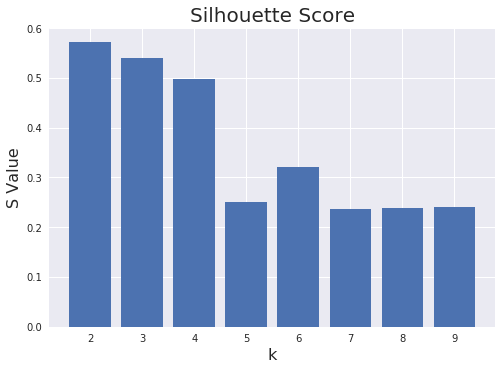

In [439]:
s = np.zeros(8)
for nc in range(0, 8):
    km = KMeans(n_clusters=nc+2, random_state=444).fit(time_series_st)
    s[nc] = silhouette_score(time_series_st, km.labels_)
    print('At {} clusters, silhouette score is {}'.format(nc+2, s[nc]))

plt.bar(range(2,10), s)
plt.xlabel('k', fontsize = 16)
plt.ylabel('S Value', fontsize = 16)
plt.title('Silhouette Score', fontsize = 20)

**Figure1**: Silhouette Score for different K for K-means clustering. The higher Silhouette Score (closer to 1) the better. Through the above graph, it seems that k=2 is the best. However, since clustering by 2 clusters are not that useful, k=4 will be chosen for following analysis.

### Choose k=4 to plot the cluster center:

In [442]:
km = KMeans(n_clusters=4, random_state=444).fit(time_series_st)
cluster_label = km.labels_
cluster_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 2, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 2, 1, 1, 3, 3, 1, 0, 1, 1, 0, 0, 0, 2, 1, 3, 3, 1, 1, 1, 0, 1, 3,
       1, 0, 1, 1, 0, 3, 1, 0, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 3, 3, 0, 3, 0,
       3, 2, 2, 1, 1, 0, 0, 0, 2, 2, 3, 2, 0], dtype=int32)

plot the cluster center under 4 clusters


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


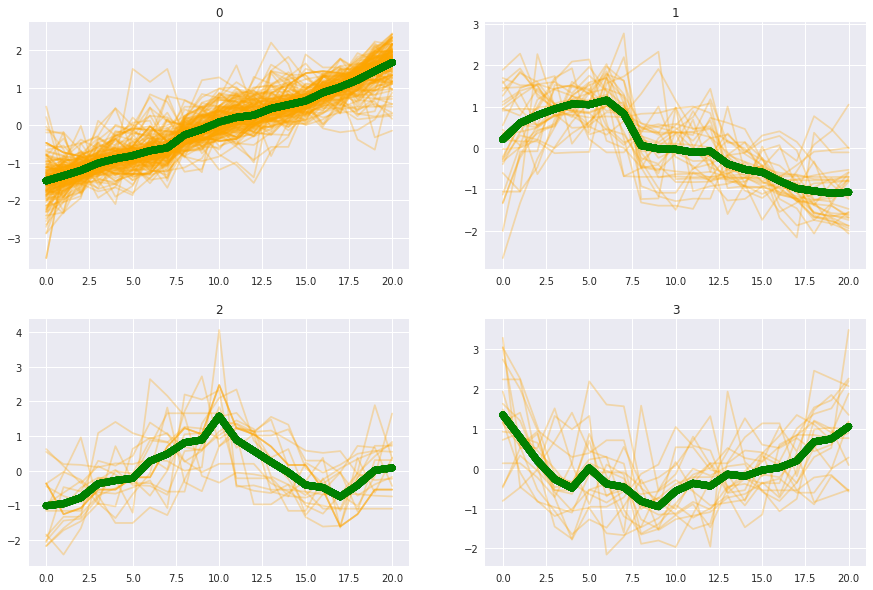

In [457]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax = [ax1, ax2, ax3, ax4]

print('plot the cluster center under 4 clusters')
for i in range(nc):
    index = np.where(cluster_label==i)
    clusteri = time_series_st.iloc[index]

    for j in range(clusteri.shape[0]):
        ax[i].plot(clusteri.iloc[j], color='orange', alpha=0.3)
        ax[i].plot(km.cluster_centers_[i], color='green', linewidth=7.0)
        ax[i].set_title(i)

**Figure 2**: Plotting the clustering center and time-series data in each clusters. The cluster labelled 0 has the most number of time series data. Following by cluster labelled 1.

### overlay the data on a NYC map

In [444]:
#check the zipcode from cleaned time-series data
zipcode_label.head()

,ZIPCODE
0,11436
1,11213
2,11212
3,11225
4,11218


In [445]:
#Based on zipcode from cleaned time-series data, merge corresponding geographic information
zipcode_label.ZIPCODE = zipcode_label.ZIPCODE.astype(int)
NYC_zipcodes.ZIPCODE = NYC_zipcodes.ZIPCODE.astype(int)
clean_geo = pd.merge(zipcode_label, NYC_zipcodes, on='ZIPCODE')
#merge the cluster label
clean_geo_label = pd.merge(clean_geo, pd.DataFrame(cluster_label), left_index=True, right_index=True)
clean_geo_label.rename(columns={0:'cluster_label'}, inplace=True)
clean_geo_label.head()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,cluster_label
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,...",0
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",0
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1...",0
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,...",0
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,...",0


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Text(0.5,1,'NYU map colored based on K-means clustering')

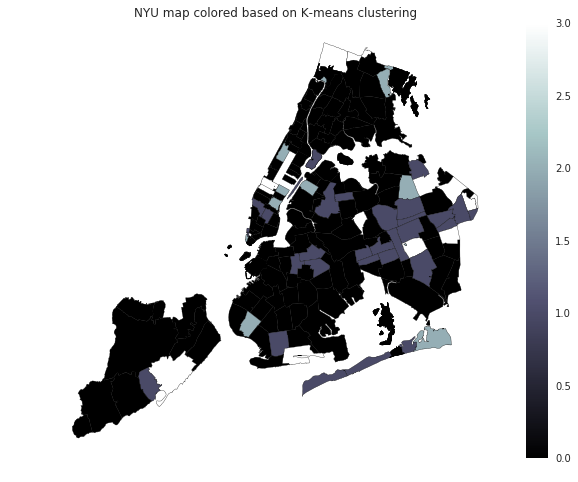

In [455]:
fig, ax = plt.subplots(figsize=(10,8))
ax.axis('off')
clean_geo_label = gpd.GeoDataFrame(clean_geo_label)
clean_geo_label.plot(column='cluster_label', edgecolor='black', cmap='bone', legend=True, ax=ax) 
ax.set_title('NYU map colored based on K-means clustering')

**Figure 3:** cloropleth of cluster centers for 4 k-means clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. From Figure 2, we can see that the cluster 0 has upwards trend, cluster 2 has downward trends, cluster 3 has discontinuities (first increase than suddenly decrease), and cluster 4 first decrease than increase but roughly maintain as the same amount. The most zipcode area are belonging to the cluster 0, indicationg that the whole business environment in New York is in good development.

# Method 2: agglomerative clustering

In [521]:
from sklearn.cluster import AgglomerativeClustering
nc = 4
agc = AgglomerativeClustering(n_clusters=nc, linkage='average').fit(time_series_st)
label_ag = agc.labels_

In [522]:
label_ag

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 3, 0, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 1, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 1, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 2, 1, 0, 0, 3, 0, 0, 1, 2, 0, 0,
       0, 2, 0, 0, 2, 2, 0, 2, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 2, 2,
       0, 1, 1, 1, 0, 2, 2, 2, 1, 1, 2, 1, 2])

In [523]:
#merge the label from AgglomerativeClustering
clean_geo_label = pd.merge(clean_geo_label, pd.DataFrame(label_ag), left_index=True, right_index=True)
clean_geo_label.rename(columns={0:'label_ag'}, inplace=True)
clean_geo_label.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,cluster_label,label_ag
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,...",0,2
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",0,2
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1...",0,2
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,...",0,2
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,...",0,2


# Comparing the results of two methods

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Text(0.5,1,'NYU map colored based on Agglomerative clustering')

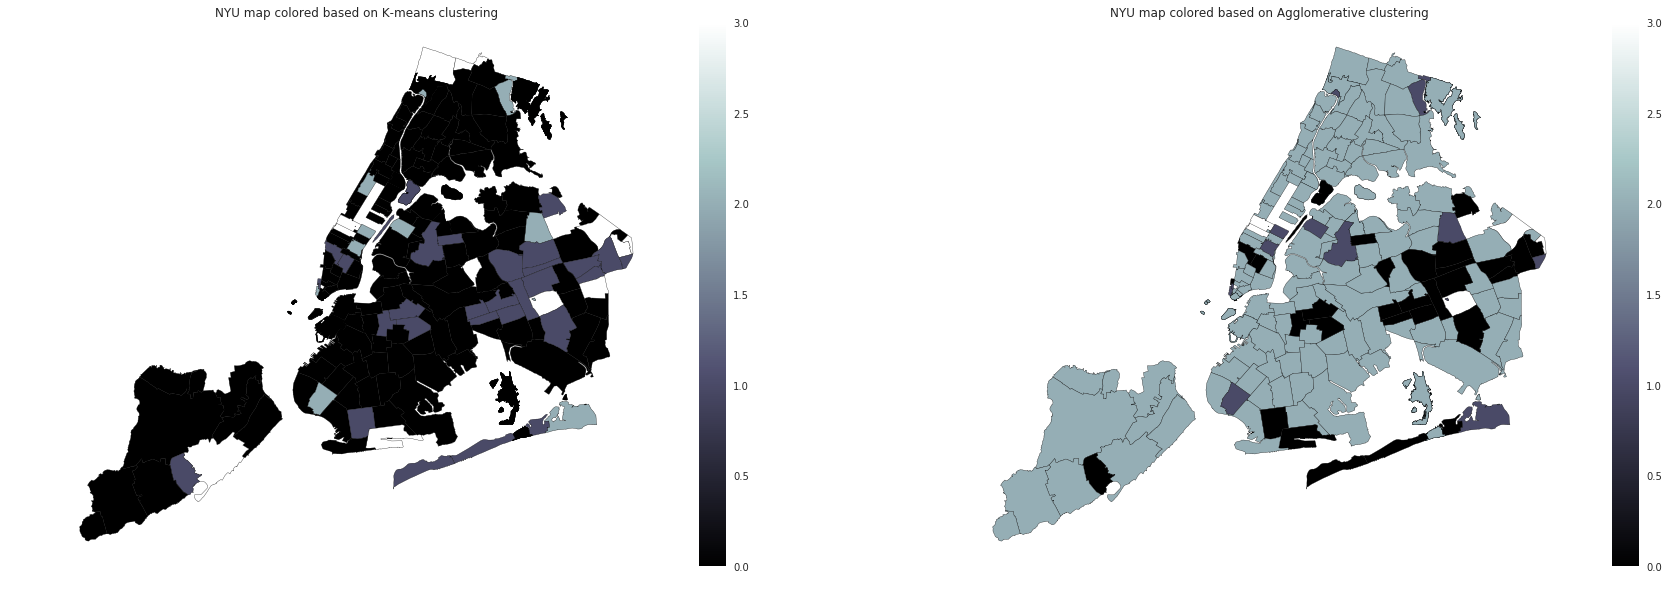

In [531]:
clean_geo_label = gpd.GeoDataFrame(clean_geo_label)

fig = plt.figure(figsize=(30,10))
ax1 = fig.add_subplot(121)
clean_geo_label.plot(column='cluster_label', edgecolor='black', cmap='bone', legend=True, ax=ax1)
ax1.axis('off')
ax1.set_title('NYU map colored based on K-means clustering')

ax2 = fig.add_subplot(122)
clean_geo_label.plot(column='label_ag', edgecolor='black', cmap='bone', legend=True, ax=ax2) 
ax2.axis('off')
ax2.set_title('NYU map colored based on Agglomerative clustering')

**Figure 4:** cloropleth of cluster centers for 4 k-means clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. These plots compare the clustering results from K-means clustering and agglomerative clustering. Besides some slight difference, most states are clusted in the same group from two methods.

# Try Method 3: hierarchical clustering 

In [552]:
from scipy.cluster.hierarchy import fcluster

In [553]:
Z = scp.hierarchy.linkage(np.asarray(time_series_st), method='ward')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


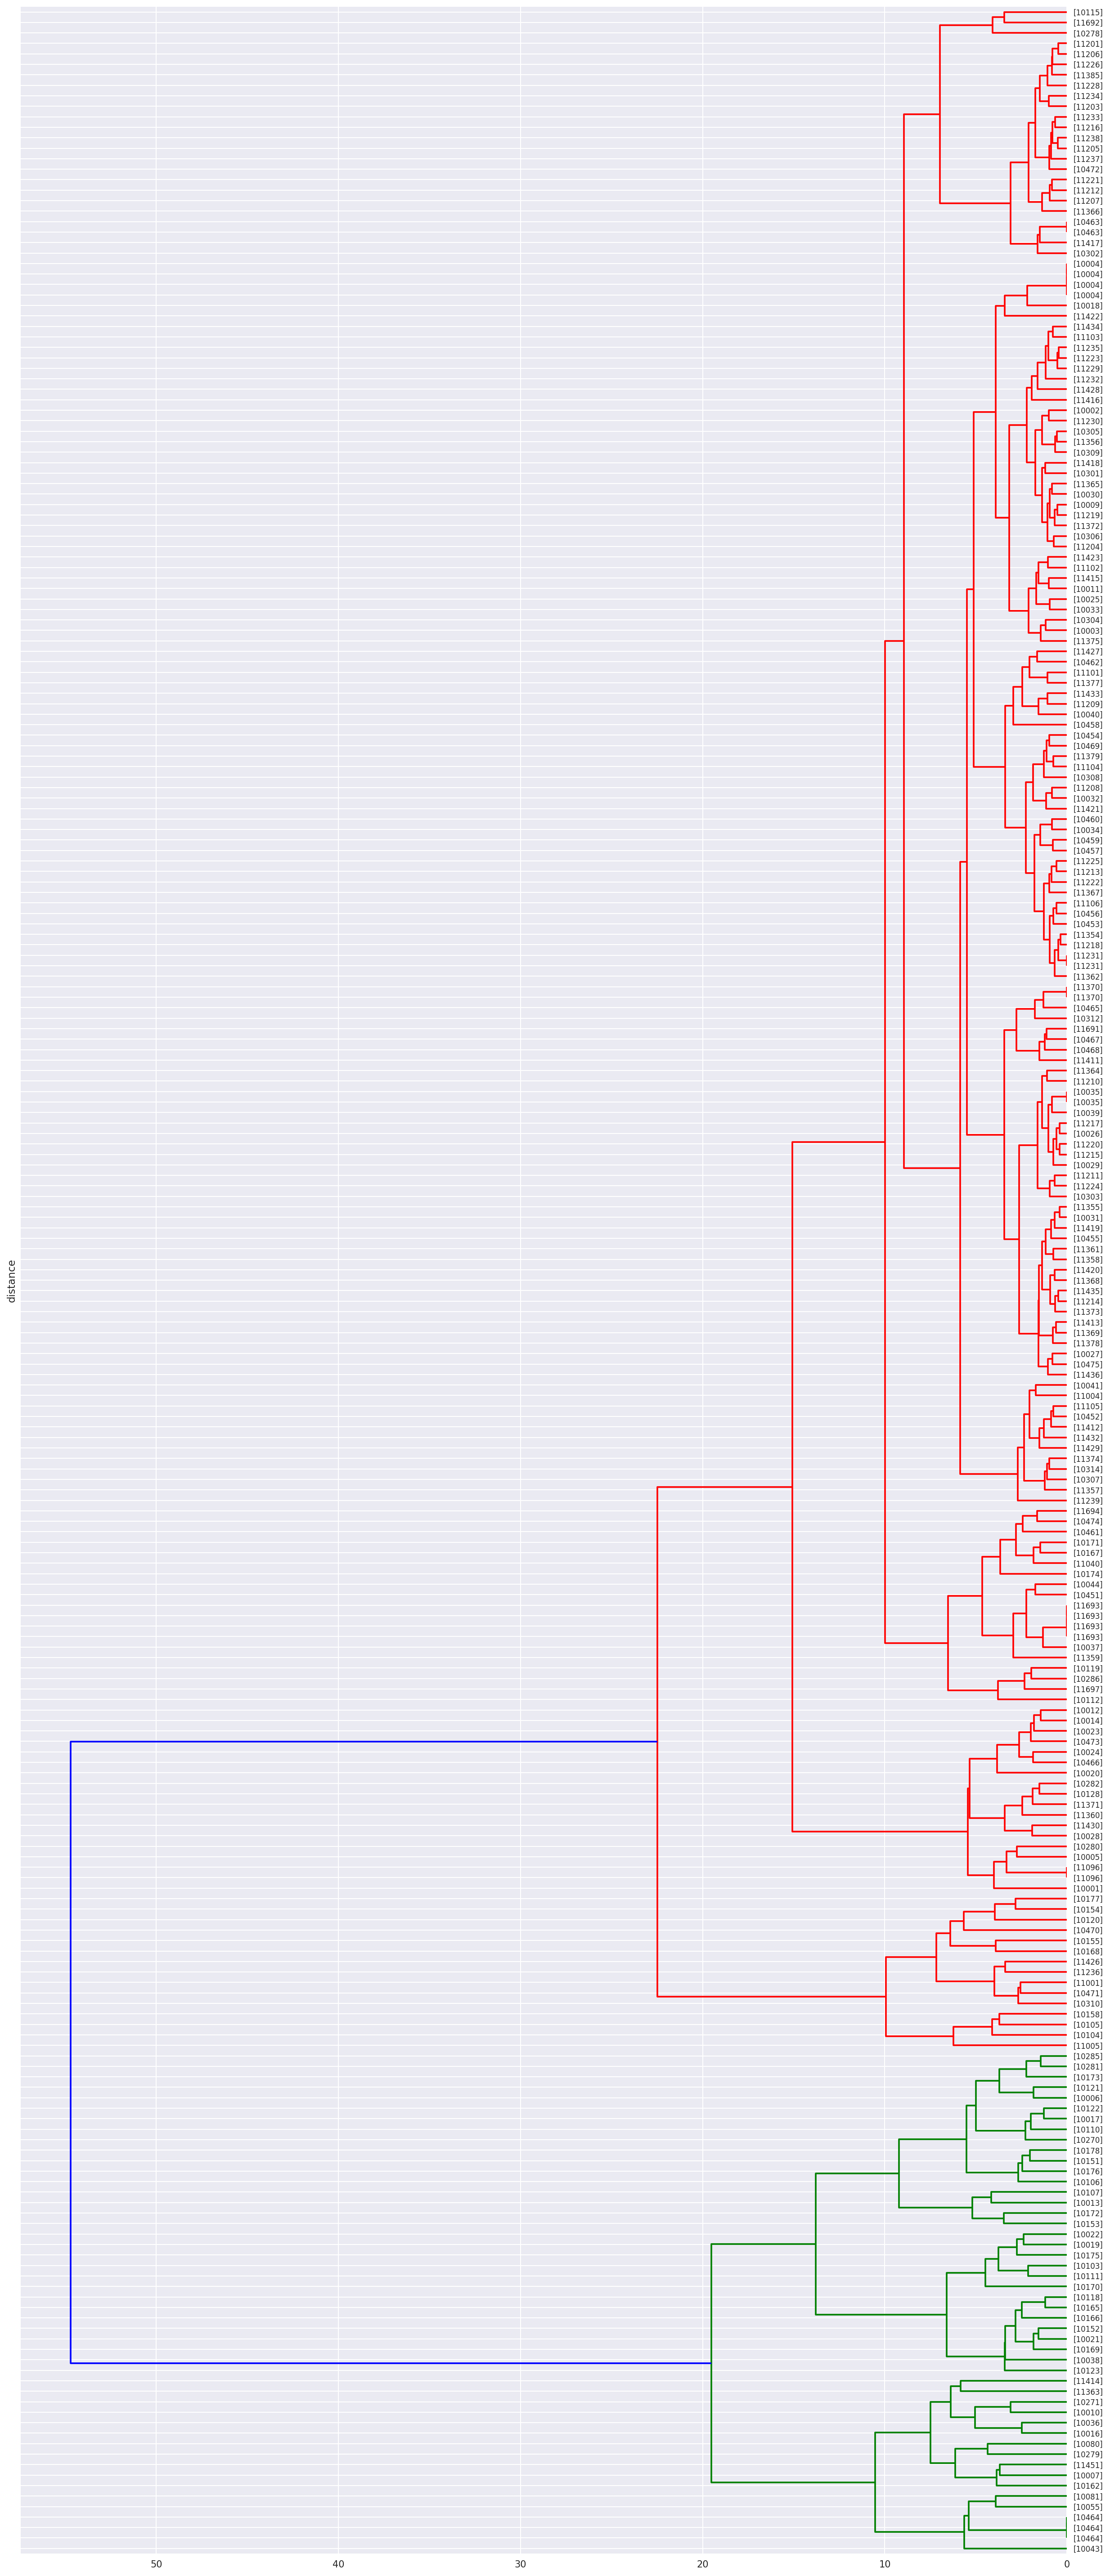

In [554]:
import scipy.cluster as scp
fig = plt.figure(figsize=(20,50), dpi=150)
plt.ylabel("distance")
ddg = scp.hierarchy.dendrogram(Z,
                               labels = zipcode_label.values,
                               leaf_font_size = 8,
                               orientation = 'left')

In [557]:
k=4
label_hier = fcluster(Z, k, criterion='maxclust')

In [558]:
#merge the label from hierarchical clustering
clean_geo_label = pd.merge(clean_geo_label, pd.DataFrame(label_hier), left_index=True, right_index=True)
clean_geo_label.rename(columns={0:'label_hier'}, inplace=True)
clean_geo_label.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,cluster_label,label_ag,label_hier
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,...",0,2,4
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",0,2,4
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1...",0,2,4
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,...",0,2,4
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,...",0,2,4


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Text(0.5,1,'NYU map colored based on Hierarchical clustering')

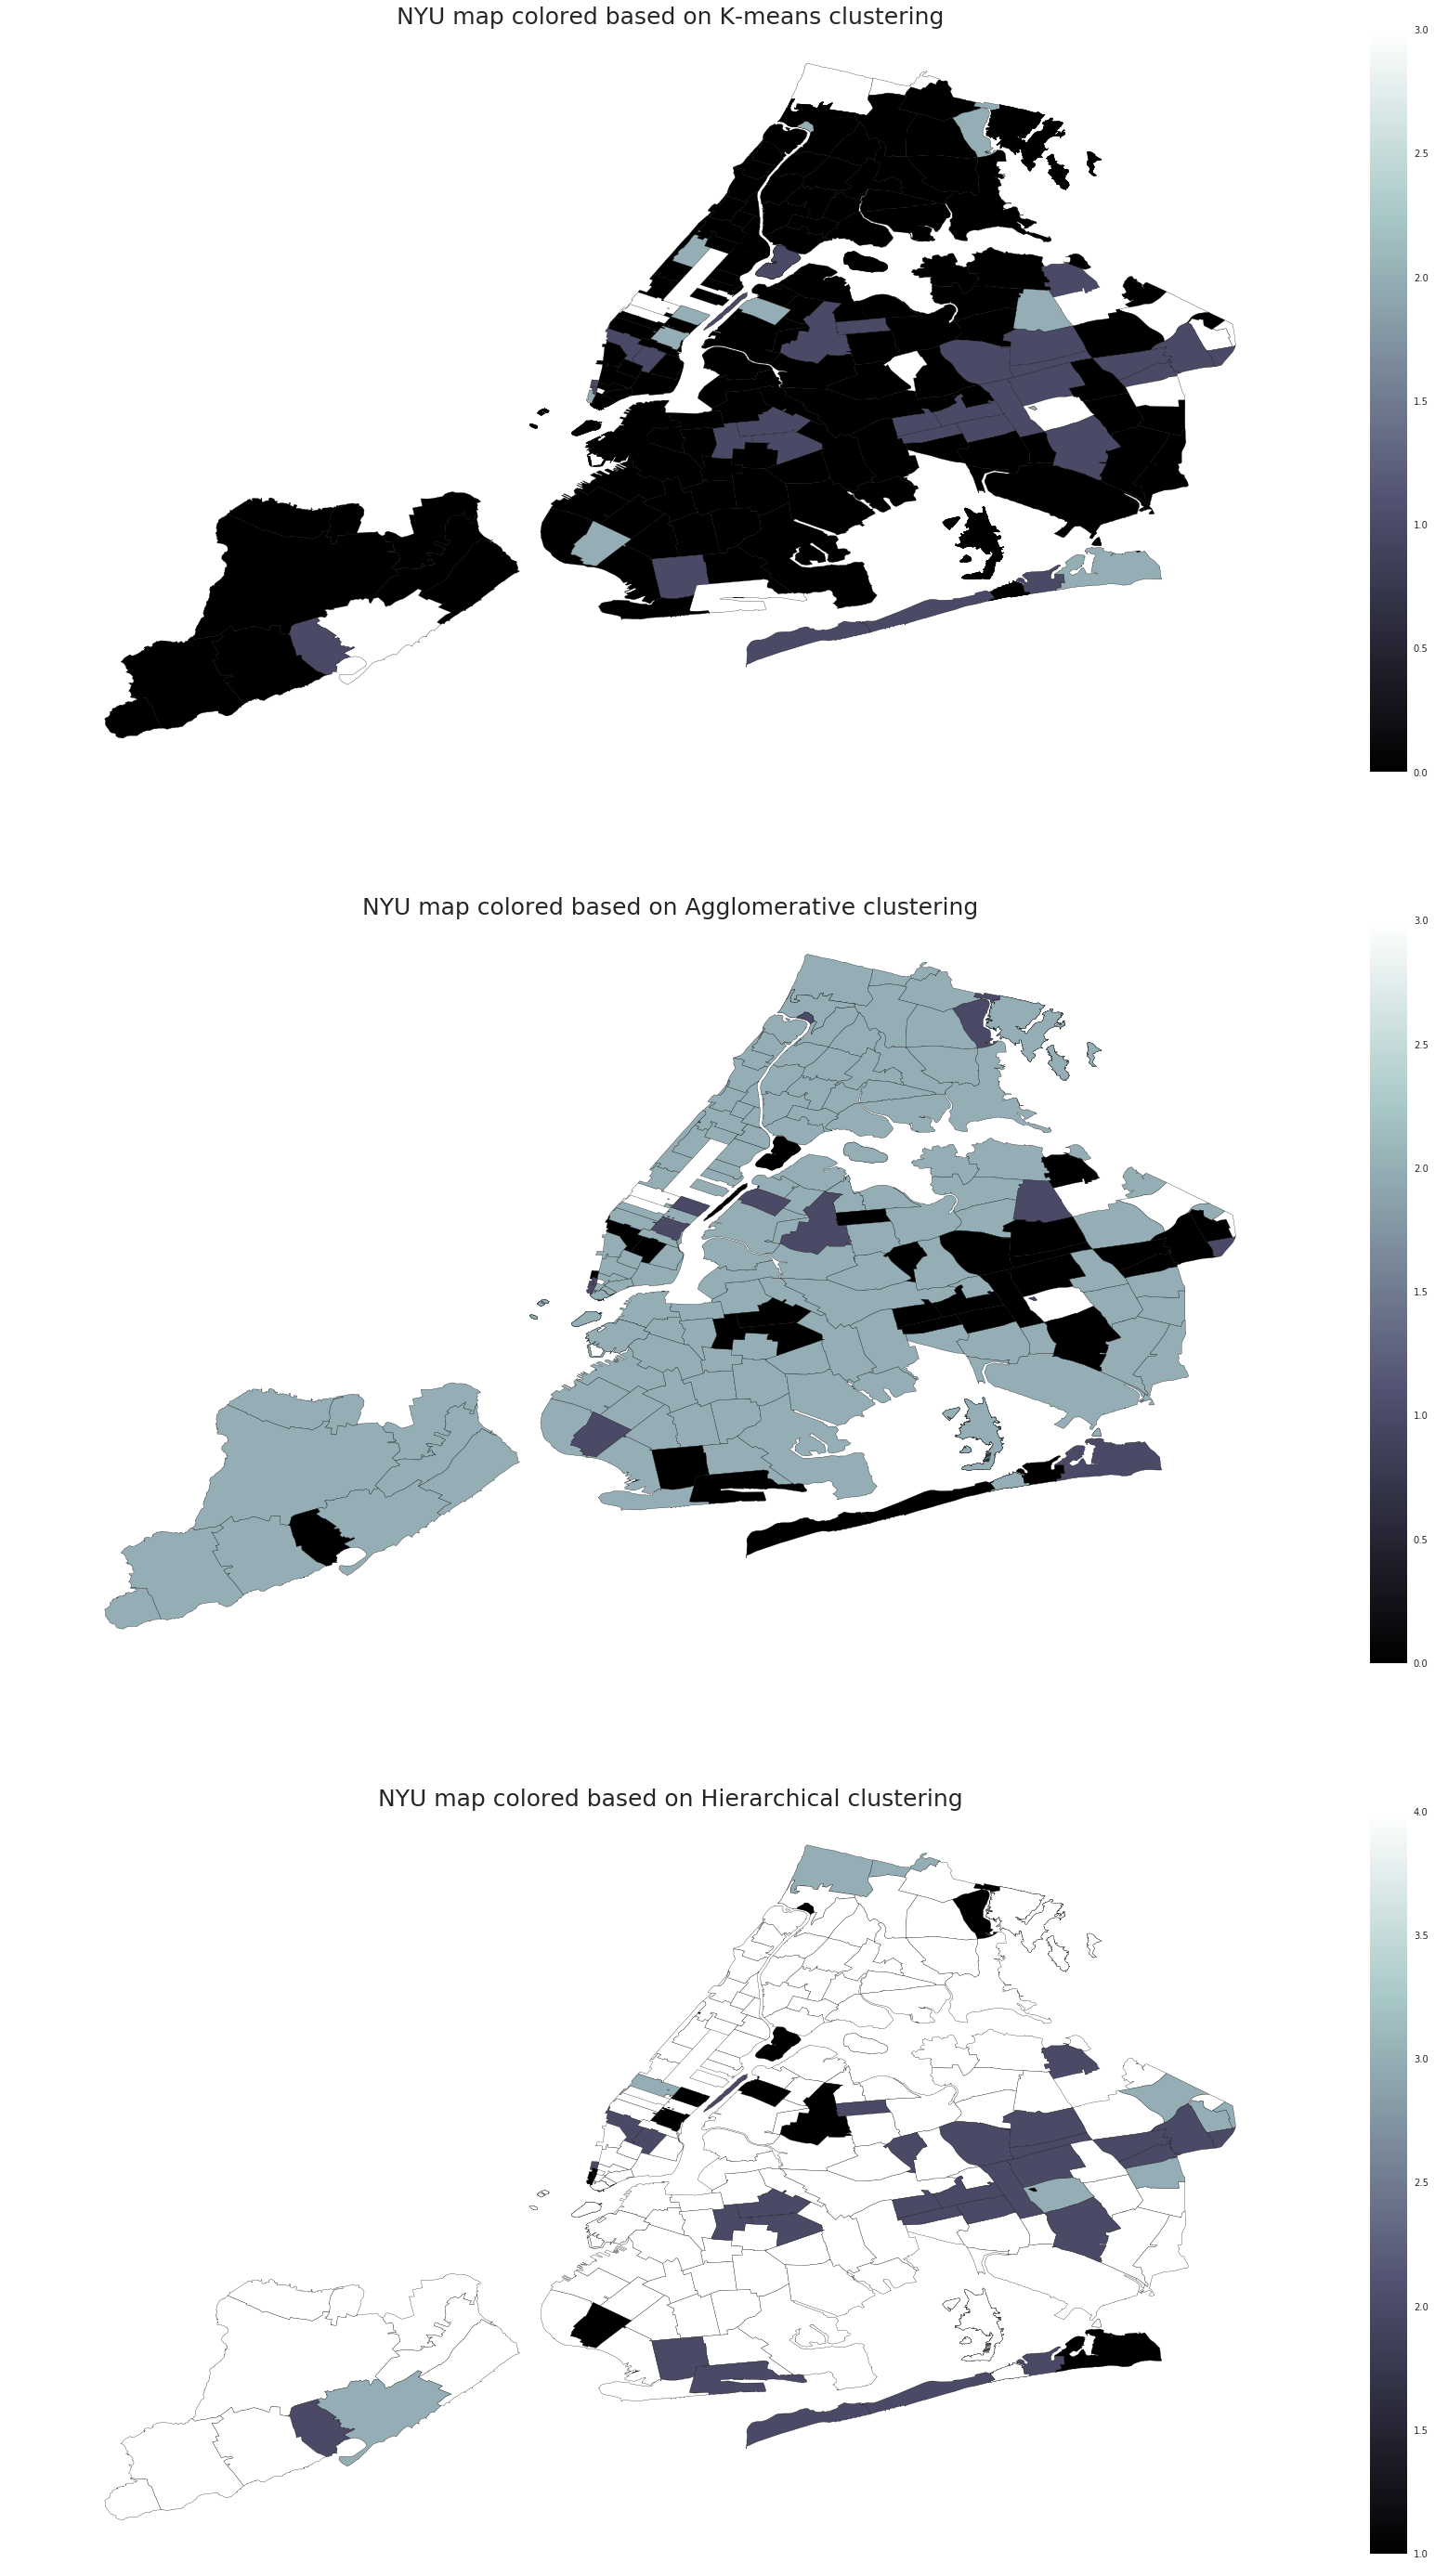

In [563]:
clean_geo_label = gpd.GeoDataFrame(clean_geo_label)

fig = plt.figure(figsize=(30,50))
ax1 = fig.add_subplot(311)
clean_geo_label.plot(column='cluster_label', edgecolor='black', cmap='bone', legend=True, ax=ax1)
ax1.axis('off')
ax1.set_title('NYU map colored based on K-means clustering', fontsize=25)

ax2 = fig.add_subplot(312)
clean_geo_label.plot(column='label_ag', edgecolor='black', cmap='bone', legend=True, ax=ax2) 
ax2.axis('off')
ax2.set_title('NYU map colored based on Agglomerative clustering', fontsize=25)

ax3 = fig.add_subplot(313)
clean_geo_label.plot(column='label_hier', edgecolor='black', cmap='bone', legend=True, ax=ax3) 
ax3.axis('off')
ax3.set_title('NYU map colored based on Hierarchical clustering', fontsize=25)

**Figure 5:** cloropleth of cluster centers for 4 k-means clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. These plots compare the clustering results from K-means clustering, agglomerative clustering, and hierarchical clustering. Besides some slight difference, most states are clusted in the same group from two methods.

# Interpretation

The three clustering methods all give the similar results. An establishment is a single physical location at which business is conducted and/or services are provided. It is not necessarily identical with a company or enterprise, which may consist of one establishment or more. Economic census figures represent a summary of reports for individual establishments rather than companies. For cases where a census report was received, separate information was obtained for each location where business was conducted. 
 
When two activities or more were carried on at a single location under a single ownership, all activities generally were grouped together as a single establishment. The entire establishment was classified on the basis of its major activity and all data for it were included in that classification. However, when distinct and separate economic activities (for which different industry classification codes were appropriate) were conducted at a single location under a single ownership, separate establishment reports for each of the different activities were obtained in the census. 

From the clustering results, the place that clustred by the number og establishment always shows a kind of spatial clustering, may indicating that the owners tend to have the ownership in the nearby location.